# Predicción de anomalías, en el sector industrial

 __Nombre:__ Adonis González

## 1. Inicialización y carga de utilidades

In [1]:
import sys  
sys.path.insert(0, '../src/')

from imports import *
from plot_functions import * 
from model_functions import *
from data_functions import *
from metric_fuctions import *

## 2. Preprocesado necesario para regressors

In [2]:
# paths 
ROOT_DIR = os.path.abspath("../")
data_dir = os.path.join(ROOT_DIR, "data")
data_1 = os.path.join(data_dir, "1")
train = os.path.join(data_1, "PM_train.csv")
test = os.path.join(data_1, "PM_test.csv")
gtruth = os.path.join(data_1, "PM_truth.csv")

sensores = ["measure_" + str(i) for i in range(1, 22)]
col_names=["id", "cycle_time", "op_sett_1", "op_sett_2", "op_sett_3"] + sensores
print(col_names)

# cargamos datos como dataframes
df_train = pd.read_csv(train, sep=";", header=None)
df_test = pd.read_csv(test, sep=";", header=None)
df_truth = pd.read_csv(gtruth, sep=";", header=None)

df_train.columns = col_names
df_test.columns = col_names


check_df_null(df_train)
check_df_null(df_test)

df_train.drop(columns=['op_sett_3',
                       'measure_1',
                       'measure_5',
                       'measure_10',
                       'measure_16',
                       'measure_18',
                       'measure_19'],inplace=True)

df = prepare_train_data(df_train)

id_col = pd.DataFrame(df["id"])

train_df = df.drop(columns = ['id','op_sett_1','op_sett_2','measure_6', 'measure_14'])


df_test.drop(columns=['measure_18',
                      'measure_19',
                      'measure_5',
                      'measure_1',
                      'op_sett_3',
                      'measure_16',
                      'measure_10',
                      'op_sett_1',
                      'op_sett_2',
                      'measure_6',
                      'measure_14'
                     ],inplace=True)


test_max = df_test.groupby('id')['cycle_time'].max().reset_index()
test_max.columns = ['id','max']
df_test = df_test.merge(test_max, on=['id'], how='left')
test = df_test[df_test['cycle_time'] == df_test['max']].reset_index()


test.drop(columns=['index',
                   'max',
                   'id'
                   ], inplace=True)


# y_true, variable con los ground truth en forma numpy
y_true = df_truth[0].to_numpy()
# test en forma numpy
X_001_test = test.to_numpy()

['id', 'cycle_time', 'op_sett_1', 'op_sett_2', 'op_sett_3', 'measure_1', 'measure_2', 'measure_3', 'measure_4', 'measure_5', 'measure_6', 'measure_7', 'measure_8', 'measure_9', 'measure_10', 'measure_11', 'measure_12', 'measure_13', 'measure_14', 'measure_15', 'measure_16', 'measure_17', 'measure_18', 'measure_19', 'measure_20', 'measure_21']


In [3]:
def normalize(df):
    cols_norm = df.columns.difference(['id', 'cycle_time', 'RUL']) 
    min_max_scaler = MinMaxScaler()
    norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(df[cols_norm]),
                                 columns=cols_norm,
                                 index=df.index)

    join_df = df[df.columns.difference(cols_norm)].join(norm_train_df)
    train_df = join_df.reindex(columns=df.columns)
    return train_df

In [4]:
def data_preprocessing(train_df, test_df, truth_df, seq_len = 50):
    rul = pd.DataFrame(test_df.groupby('id')['cycle_time'].max()).reset_index()
    rul.columns = ['id', 'max']
    truth_df.columns = ['more']
    truth_df['id'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more']  
    truth_df.drop('more', axis=1, inplace=True)

    test_df = test_df.merge(truth_df, on=['id'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['cycle_time']
    test_df.drop('max', axis=1, inplace=True)

    seq_cols = list(test_df.columns[:-1])  # todas menos, RUL
    val = list(gen_sequence(train_df[train_df['id'] == 1], seq_len, seq_cols))
    seq_gen = (list(gen_sequence(train_df[train_df['id'] == x], seq_len, seq_cols)) for x in train_df['id'].unique())
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    label_gen = [gen_labels(train_df[train_df['id'] == id], seq_len, ['RUL']) for id in train_df['id'].unique()]
    label_array = np.concatenate(label_gen).astype(np.float32)

    return seq_array, label_array, test_df, seq_len, seq_cols

In [5]:
train_df_lstm = pd.concat([id_col, train_df], axis=1)
train_df_lstm = normalize(train_df_lstm)

test_df = df_test.drop(columns=['max'])
test_df = normalize(test_df)

In [6]:
seq_array, lbl_array, lstm_test_df, seq_len, seq_cols = data_preprocessing(train_df_lstm, 
                                                                             test_df,          
                                                                             df_truth)

## 3. LSTM

In [7]:
LR = 0.001
BATCH_SIZE = 200
EPOCHS = 100

In [8]:
def create_model_lstm(seq_array, lbl_array, seq_len):
    nb_features = seq_array.shape[2]
    nb_out = lbl_array.shape[1]
    model = Sequential()
    model.add(LSTM(input_shape=(seq_len, nb_features),units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    return model

In [9]:
def compile_model(model, lr=LR):
    optimizer = tf.keras.optimizers.RMSprop(lr=lr)
    loss = 'mean_squared_error'
    model.compile(optimizer=optimizer, loss=loss, metrics=['mae', r2_keras])
    return model

In [10]:
METRIC = "r2_keras"
PATH = './model.h5'

def create_callbacks(metric = METRIC, path = PATH):
    checkpoint = ModelCheckpoint(
        filepath=path,
        monitor= metric,
        mode='max',
        save_best_only=True,
        verbose=1)

    reducelr = ReduceLROnPlateau(
        monitor= metric,
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0)

    eS = EarlyStopping(
        monitor= metric,
        mode='max',
        patience=10, 
        verbose=2)
    
    callbacks = [checkpoint, reducelr, eS]         
    return callbacks

In [11]:
callbacks = create_callbacks(path='./model_lstm.h5')

In [12]:
model = create_model_lstm(seq_array, lbl_array, seq_len)
model = compile_model(model)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           46400     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 76,651
Trainable params: 76,651
Non-trainable params: 0
____________________________________________________

In [13]:
history = model.fit(seq_array, 
                    lbl_array, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=0.1, 
                    verbose=2,
                    callbacks=callbacks)

Epoch 1/100
71/71 - 6s - loss: 8665.0957 - mae: 74.9092 - r2_keras: -1.7816e+00 - val_loss: 11301.4756 - val_mae: 84.7849 - val_r2_keras: -2.1272e+00

Epoch 00001: r2_keras improved from -inf to -1.78157, saving model to .\model_lstm.h5
Epoch 2/100
71/71 - 1s - loss: 7979.0771 - mae: 70.8675 - r2_keras: -1.5578e+00 - val_loss: 10710.6484 - val_mae: 81.7739 - val_r2_keras: -1.9377e+00

Epoch 00002: r2_keras improved from -1.78157 to -1.55777, saving model to .\model_lstm.h5
Epoch 3/100
71/71 - 1s - loss: 7494.1069 - mae: 68.0181 - r2_keras: -1.4091e+00 - val_loss: 10147.4531 - val_mae: 78.9195 - val_r2_keras: -1.7585e+00

Epoch 00003: r2_keras improved from -1.55777 to -1.40906, saving model to .\model_lstm.h5
Epoch 4/100
71/71 - 1s - loss: 7033.3223 - mae: 65.3484 - r2_keras: -1.2559e+00 - val_loss: 9609.0420 - val_mae: 76.2105 - val_r2_keras: -1.5888e+00

Epoch 00004: r2_keras improved from -1.40906 to -1.25586, saving model to .\model_lstm.h5
Epoch 5/100
71/71 - 1s - loss: 6603.6250 

71/71 - 1s - loss: 1002.2407 - mae: 20.8309 - r2_keras: 0.6824 - val_loss: 2064.4304 - val_mae: 33.1210 - val_r2_keras: 0.4876

Epoch 00036: r2_keras improved from 0.66683 to 0.68241, saving model to .\model_lstm.h5
Epoch 37/100
71/71 - 1s - loss: 960.7075 - mae: 20.4692 - r2_keras: 0.6939 - val_loss: 2269.6482 - val_mae: 35.0090 - val_r2_keras: 0.4262

Epoch 00037: r2_keras improved from 0.68241 to 0.69391, saving model to .\model_lstm.h5
Epoch 38/100
71/71 - 1s - loss: 925.3290 - mae: 19.9798 - r2_keras: 0.7051 - val_loss: 1694.0175 - val_mae: 29.9038 - val_r2_keras: 0.5649

Epoch 00038: r2_keras improved from 0.69391 to 0.70511, saving model to .\model_lstm.h5
Epoch 39/100
71/71 - 1s - loss: 900.1122 - mae: 19.8360 - r2_keras: 0.7144 - val_loss: 1645.5641 - val_mae: 29.3824 - val_r2_keras: 0.5659

Epoch 00039: r2_keras improved from 0.70511 to 0.71444, saving model to .\model_lstm.h5
Epoch 40/100
71/71 - 1s - loss: 875.1031 - mae: 19.3945 - r2_keras: 0.7207 - val_loss: 1694.7946 - v


Epoch 00073: r2_keras did not improve from 0.84620
Epoch 74/100
71/71 - 1s - loss: 461.3730 - mae: 14.1230 - r2_keras: 0.8530 - val_loss: 1408.0302 - val_mae: 27.6274 - val_r2_keras: 0.5610

Epoch 00074: r2_keras improved from 0.84620 to 0.85297, saving model to .\model_lstm.h5
Epoch 75/100
71/71 - 1s - loss: 465.4162 - mae: 14.1561 - r2_keras: 0.8511 - val_loss: 1636.2458 - val_mae: 29.4024 - val_r2_keras: 0.4746

Epoch 00075: r2_keras did not improve from 0.85297
Epoch 76/100
71/71 - 1s - loss: 453.0587 - mae: 13.9913 - r2_keras: 0.8549 - val_loss: 1361.0115 - val_mae: 26.5405 - val_r2_keras: 0.5118

Epoch 00076: r2_keras improved from 0.85297 to 0.85488, saving model to .\model_lstm.h5
Epoch 77/100
71/71 - 1s - loss: 446.0197 - mae: 13.9329 - r2_keras: 0.8576 - val_loss: 1499.3531 - val_mae: 29.3124 - val_r2_keras: 0.4780

Epoch 00077: r2_keras improved from 0.85488 to 0.85760, saving model to .\model_lstm.h5
Epoch 78/100
71/71 - 1s - loss: 446.5352 - mae: 13.9643 - r2_keras: 0.856

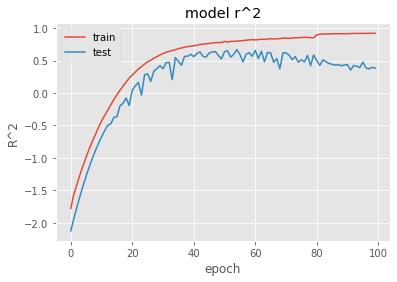

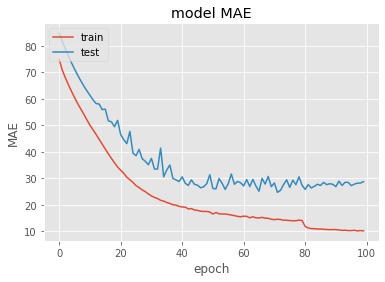

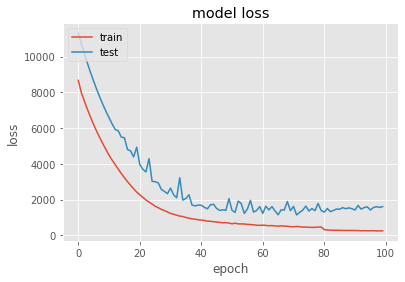

79/79 [==============================] - 0s 5ms/step - loss: 302.0139 - mae: 9.1399 - r2_keras: 0.8847

MAE: 9.139935493469238

R^2: 0.8847090601921082
79/79 [==============================] - 1s 5ms/step


In [14]:
lstm_evaluation(model, history, seq_array, lbl_array)

3/3 - 0s - loss: 1309.3867 - mae: 30.9496 - r2_keras: 0.1834

MAE: 30.949628829956055

R^2: 0.1833559274673462
           0
0  17.098042
1  33.204308
2  33.096554
3  45.852455
4  83.832916


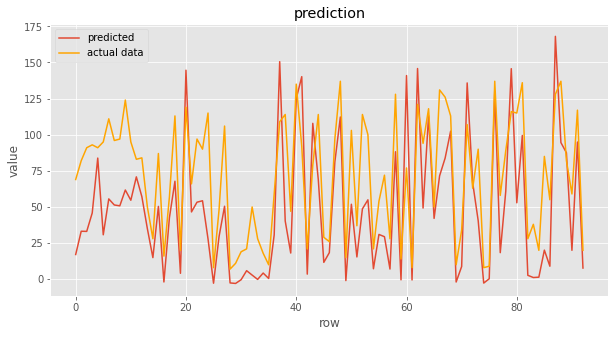

In [15]:
MAE, R2 = lstm_test_eval(lstm_test_df, model, seq_len, seq_cols)